In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [ ]:
imgPath_train = "/kaggle/input/ml100-03-final/image_data/train/"
imgPath_test = "/kaggle/input/ml100-03-final/image_data/test/"

flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}

In [ ]:
img = cv2.imread(imgPath_test+"0028624c49b3e0610ff9f1d111f5d532.jpg", cv2.IMREAD_COLOR)
print(img.shape)
r,g,b = cv2.split(img)
plt.imshow(cv2.merge([b,g,r]))

In [ ]:
trainAll=[]
trainY = []

for flowerType in os.listdir(imgPath_train):
    try: 
        path = imgPath_train+flowerType+"/"
        for imgFileName in os.listdir(path):
            id = imgFileName[:-4]
            trainAll.append(cv2.imread(path+imgFileName, cv2.IMREAD_COLOR))
            trainY.append(flower_mapping[flowerType])
    except: 
        print("No mapping data.")
        
print(trainY[0])
plt.imshow(trainAll[0])

In [ ]:
testX = {}
for imgFileName in os.listdir(imgPath_test):
    testX[imgFileName[:-4]] = cv2.imread(imgPath_test+imgFileName, cv2.IMREAD_COLOR)
plt.imshow(testX['0028624c49b3e0610ff9f1d111f5d532'])    

In [ ]:
amount = len(trainAll)
image_new_shape = (128,128,3)
trainX = np.empty(shape=(amount,)+image_new_shape, dtype=np.uint8)
for index in range(amount):
    r,g,b = cv2.split(trainAll[index])
    r = np.array(Image.fromarray(r).resize((128,128)))
    g = np.array(Image.fromarray(g).resize((128,128)))
    b = np.array(Image.fromarray(b).resize((128,128)))
    trainX[index] = cv2.merge([r,g,b])
    
print(trainX[100].shape)
plt.imshow(trainX[100])

In [ ]:
x_train = np.asarray(trainX)
y_train = np.asarray(trainY)
x_test = testX.values()

In [ ]:
#hyperparameter
batch_size = 128 
num_classes = 5
epochs = 20 

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
x_train = x_train.astype('float32')
x_train /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)

In [ ]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:], kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=2, padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:], kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

In [ ]:
verTest = list(x_test)
amount = len(x_test)
image_new_shape = (128,128,3)
testY = np.empty(shape=(amount,)+image_new_shape, dtype=np.uint8)
for index in range(amount):
    r,g,b = cv2.split(verTest[index])
    r = np.array(Image.fromarray(r).resize((128,128)))
    g = np.array(Image.fromarray(g).resize((128,128)))
    b = np.array(Image.fromarray(b).resize((128,128)))
    testY[index] = cv2.merge([r,g,b])
    
plt.imshow(testY[0])

In [ ]:
testY = testY.astype('float32')
testY /= 255
preds = model.predict(testY)

keys = list(testX.keys())
print(keys[200], preds[200])
plt.imshow(testY[200])

In [ ]:
plt.imshow(testX[keys[200]])

In [ ]:
mname = type(model).__name__
pd.DataFrame({'id': keys, 'flowerType': np.argmax(preds, axis=1)}).to_csv('finalExam_model_50.csv', index=False)

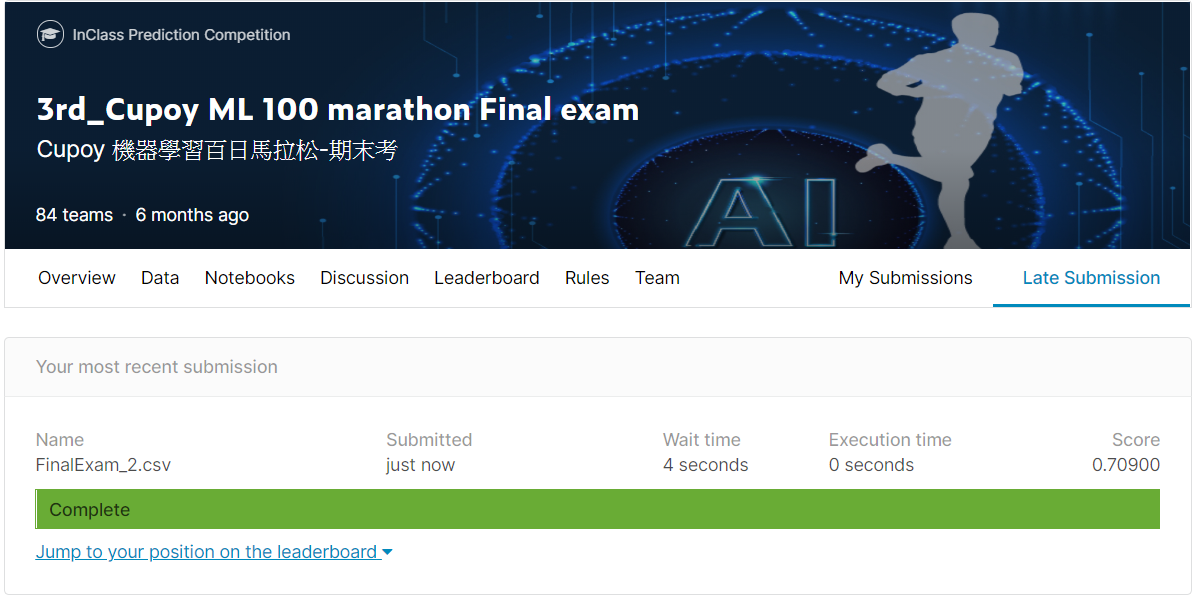